<a href="https://www.kaggle.com/code/jeanarnonalves/titanic-competition?scriptVersionId=127498452" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**Notebook by Jean Arnon Alves - note: most of the code here was taken from the Feature Engineering course**

Initialization

In [1]:
import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from pandas.api.types import CategoricalDtype

from category_encoders import MEstimateEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBClassifier


# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

# Mute warnings
warnings.filterwarnings('ignore')

Function to load and preprocess data

In [2]:
def load_data():
    # Read data
    data_dir = Path("/kaggle/input/titanic")
    df_train = pd.read_csv(data_dir / "train.csv", index_col="PassengerId")
    df_test = pd.read_csv(data_dir / "test.csv", index_col="PassengerId")
    # Merge the splits so we can process them together
    df = pd.concat([df_train, df_test])
    # Preprocessing
    #df = clean(df)
    df = encode(df)
    df = impute(df)
    # Reform splits
    df_train = df.loc[df_train.index, :]
    df_test = df.loc[df_test.index, :]
    return df_train, df_test

def importing(df_train):
    X = df_train.copy()
    y = X.pop("Survived")
    return X, y

Cleaning data

In [3]:
data_dir = Path("/kaggle/input/titanic")
row_train = pd.read_csv(data_dir / "train.csv", index_col="PassengerId")
import re

def keep_leters(text):
    if isinstance(text, str):
        t = re.sub('[^a-zA-Z]', '', text)
        return ",".join(re.findall('[a-zA-Z]', str(t)))
    else:
        return text

def filling_cabin(df):
    cabin_map = {1: 'C', 2: 'F', 3: 'G'}
    df['Cabin'] = df['Cabin'].fillna(df['Pclass'].map(cabin_map))
    return df

#row_trans = filling_cabin(row_train)
#print(row_trans.head(28))

'''row_train['Cabin'] = row_train['Cabin'].apply(keep_leters)
print(row_train.Cabin.head(28))'''


def clean(df):
    '''df['Cabin'] = df['Cabin'].apply(keep_leters)'''
    df = filling_cabin(df)
    return df

# No data cleaning for now - Possible cleaning: Name, Ticket, Cabin

Encode and Label_encode functions

In [4]:
# The nominative (unordered) categorical features
features_nom = ["Name", "Sex", "Ticket", "Cabin", "Embarked"]

# The ordinal (ordered) categorical features 
ordered_levels = {
    "Pclass": [3, 2, 1]
}
# Add a None level for missing values
ordered_levels = {key: ["None"] + value for key, value in
                  ordered_levels.items()}
    
def encode(df):
    # Nominal categories
    for name in features_nom:
        df[name] = df[name].astype("category")
        # Add a None category for missing values
        if "None" not in df[name].cat.categories:
            df[name].cat.add_categories("None", inplace=True)
    # Ordinal categories
    for name, levels in ordered_levels.items():
        df[name] = df[name].astype(CategoricalDtype(levels,
                                                    ordered=True))
    return df

def label_encode(df):
    X = df.copy()
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    return X

Missing Values

In [5]:
def impute(df):
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(29.7) # Putting the mean value
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None")
    return df

Loading data

In [6]:
df_train, df_test = load_data()
display(df_train)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S
4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,None,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0.0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,None,S
888,1.0,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0.0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,29.7,1,2,W./C. 6607,23.4500,None,S


Creating a Baseline Score

In [7]:
def score_dataset(X, y, model=XGBClassifier()):
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    # Metric for Titanic Competition is Accuracy
    score = cross_val_score(
        model, X, y, cv=5, scoring="accuracy"
    )
    score = score.mean()
    return score

def printing_score(score, text='ACCURACY'):
    print(f"{text}: {score*100:.2f} %")
    
X, y = importing(df_train)

baseline_score = score_dataset(X, y)
printing_score(baseline_score, 'Baseline ACCURACY')

Baseline ACCURACY: 81.37 %


Creating make_mi_scores and plot_mi_scores functions

Name        0.665912
Ticket      0.572496
Cabin       0.165236
Sex         0.150870
Fare        0.115435
Pclass      0.058107
SibSp       0.023197
Embarked    0.016668
Parch       0.016366
Age         0.013450
Name: MI Scores, dtype: float64


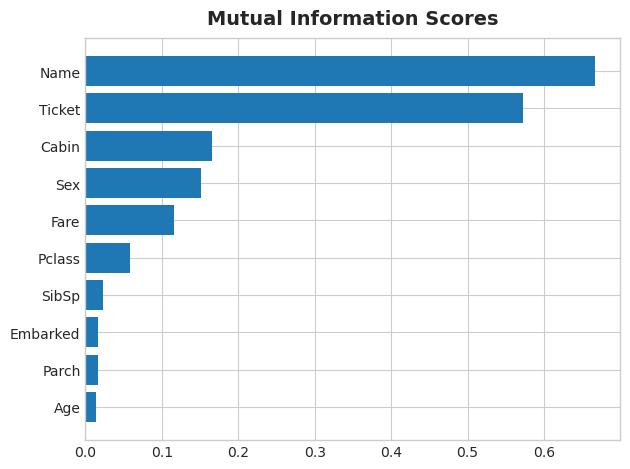

In [8]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    
X, y = importing(df_train)

mi_scores = make_mi_scores(X, y)
print(mi_scores)
plot_mi_scores(mi_scores)

Dropping uninformative features

In [9]:
def drop_uninformative(df, mi_scores):
    return df.loc[:, mi_scores > 0.10]
      
X, y = importing(df_train)
X = drop_uninformative(X, mi_scores)
new_score = score_dataset(X, y)
printing_score(new_score)

ACCURACY: 81.03 %


Dropping features with mi_scores < 0.10 didn't improve the model. So all features will be kept in

Correlation plot and matrix

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Survived,1.000000,0.338481,-0.057487,-0.543351,-0.069811,-0.035322,0.081629,-0.166734,0.257307,-0.253406,-0.163517
Pclass,0.338481,1.000000,-0.052644,-0.131900,0.331334,-0.083081,-0.018443,-0.322475,0.549500,-0.682623,-0.157112
Name,-0.057487,-0.052644,1.000000,0.021256,0.058236,-0.017345,-0.049639,0.049656,-0.048917,0.062609,-0.005555
Sex,-0.543351,-0.131900,0.021256,1.000000,0.084155,-0.114631,-0.245489,0.060416,-0.182333,0.095479,0.104057
Age,-0.069811,0.331334,0.058236,0.084155,1.000000,-0.232624,-0.179194,-0.068715,0.091563,-0.235522,-0.022243
SibSp,-0.035322,-0.083081,-0.017345,-0.114631,-0.232624,1.000000,0.414838,0.079191,0.159651,0.043342,0.066654
Parch,0.081629,-0.018443,-0.049639,-0.245489,-0.179194,0.414838,1.000000,0.019936,0.216225,-0.028329,0.038322
Ticket,-0.166734,-0.322475,0.049656,0.060416,-0.068715,0.079191,0.019936,1.000000,-0.015503,0.244702,-0.004259
Fare,0.257307,0.549500,-0.048917,-0.182333,0.091563,0.159651,0.216225,-0.015503,1.000000,-0.501474,-0.221226
Cabin,-0.253406,-0.682623,0.062609,0.095479,-0.235522,0.043342,-0.028329,0.244702,-0.501474,1.000000,0.191471


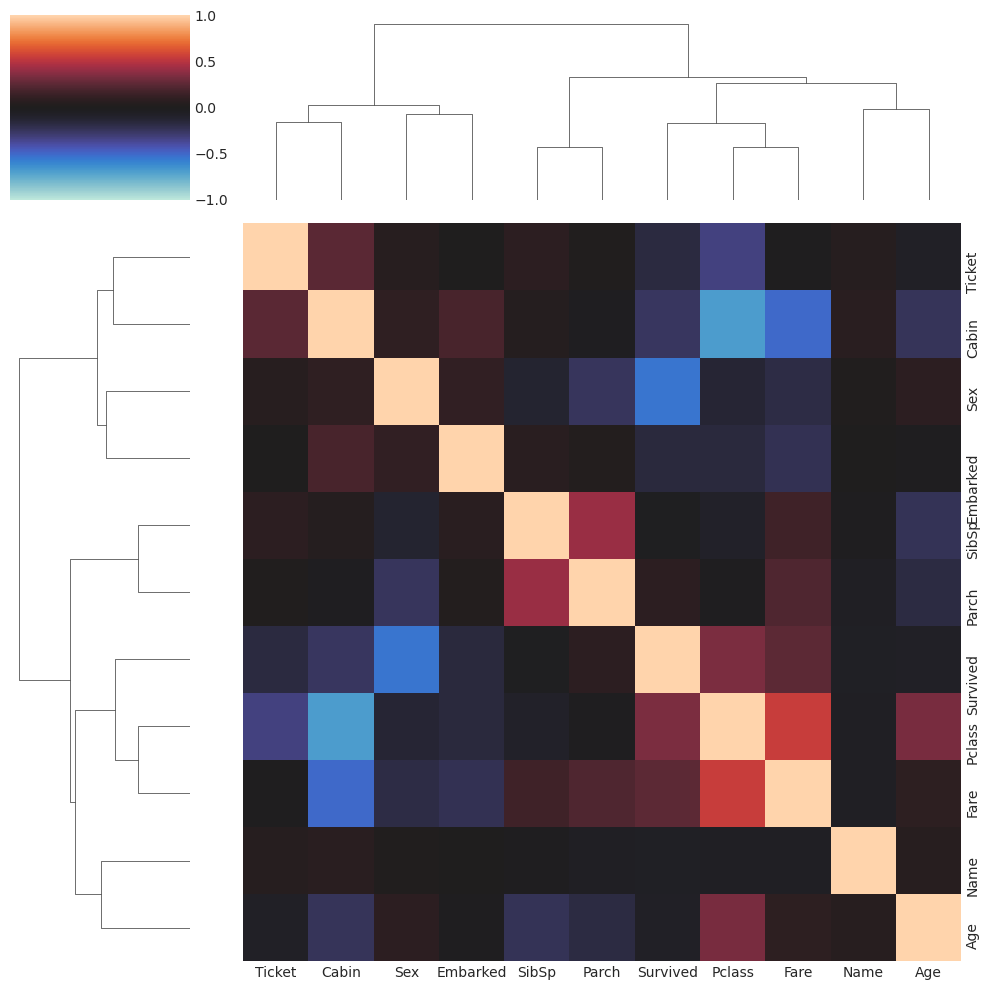

In [10]:
def corrplot(df, method="pearson", annot=True, **kwargs):
    sns.clustermap(
        df.corr(method),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=annot,
        **kwargs,
    )

X = df_train.copy()
X = label_encode(X)
corrplot(X, annot=None)
X.corr()

Based on correlation plot and matrix, we can see that some features are related to each other: Cabin-Pclass, Pclass-Fare, Sex-Survived, Cabin-Fare, Ticket-Pclass, etc.

Creating new features

In [11]:
def family(df):
    X = pd.DataFrame()
    X["Family"] = df["SibSp"] + df["Parch"]
    return X

def group_transforms(df):
    X = pd.DataFrame()
    X["MdFareClass"] = df.groupby("Pclass")["Fare"].transform("median")
    return X

def cabin_fare(df):
    X = pd.DataFrame()
    X["CabFar"] = df.groupby("Cabin")["Fare"].transform("count")
    return X

def ticket_pclass(df):
    X = pd.DataFrame()
    X["TicPcl"] = df.groupby("Pclass")["Ticket"].transform("count")
    return X

def age_sex(df):
    X = pd.DataFrame()
    X["AgSx"] = df.groupby("Sex")["Age"].transform("mean")
    return X

def age_pclass(df):
    X = pd.DataFrame()
    X["AgPc"] = df.groupby("Pclass")["Age"].transform("mean")
    return X

def find_survivor_sex(df):
    X = pd.DataFrame()
    df = df.reset_index()
    X["Find"] = df.groupby(["Sex", "Survived"])["PassengerId"].count()
    return X

def survivor_sex(df):
    X = pd.DataFrame()
    for idx in range(0, len(df), 1):
        if df['Sex'].iloc[idx] == 'male' and df['Survived'].iloc[idx] == 0:
            X.loc[idx, 'SurvSex'] = 468  
        elif df['Sex'].iloc[idx] == 'male' and df['Survived'].iloc[idx] == 1:
            X.loc[idx, 'SurvSex'] = 109
        elif df['Sex'].iloc[idx] == 'female' and df['Survived'].iloc[idx] == 0:
            X.loc[idx, 'SurvSex'] = 81
        elif df['Sex'].iloc[idx] == 'female' and df['Survived'].iloc[idx] == 1:
            X.loc[idx, 'SurvSex'] = 233
        else:
            X.loc[idx, 'SurvSex'] = 0
    X.index = range(1, len(X) + 1)
    return X

In [12]:
age_pclass(df_train).head(20)

,AgPc
PassengerId,
1,26.403503
2,37.048241
3,26.403503
4,37.048241
5,26.403503
6,26.403503
7,37.048241
8,26.403503
9,26.403503


K-Means Clustering

In [13]:
cluster_features = [
    "Age",
    "Parch",
    "SibSp",
    "Fare",
]

def cluster_labels(df, features, n_clusters=10):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=0)
    X_new = pd.DataFrame()
    X_new["Cluster"] = kmeans.fit_predict(X_scaled)
    return X_new


def cluster_distance(df, features, n_clusters=10):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=0)
    X_cd = kmeans.fit_transform(X_scaled)
    # Label features and join to dataset
    X_cd = pd.DataFrame(
        X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])]
    )
    return X_cd

Aplying PCA

In [14]:
def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

def pca_components(df, features):
    X = df.loc[:, features]
    pca, X_pca, loadings = apply_pca(X)
    return pca, X_pca, loadings

pca_features = [
    "Age",
    "Parch",
    "SibSp",
    "Fare",
    "Pclass",
]

<AxesSubplot:xlabel='Pclass', ylabel='Age'>

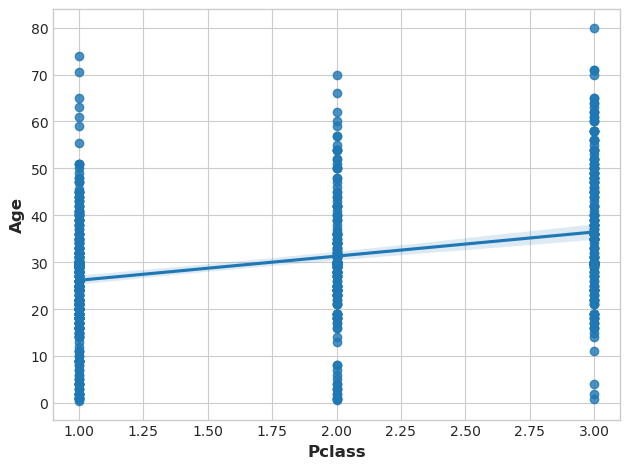

In [15]:
dft = label_encode(df_train)
pca, X_pca, loadings = pca_components(dft, pca_features)
#plot_variance(pca)
#print(loadings)
#print(X_pca)
sns.regplot(data=dft, x='Pclass', y='Age')

Target Encoding

In [16]:
class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=5)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

Final Set Feature

In [17]:
def create_features(df, df_test=None):
    X = df.copy()
    #X = X.join(survivor_sex(X))
    y = X.pop("Survived")

    # Combine splits if test data is given
    #
    # If we're creating features for test set predictions, we should
    # use all the data we have available. After creating our features,
    # we'll recreate the splits.
    if df_test is not None:
        X_test = df_test.copy()
        X_test.pop("Survived")
        X = pd.concat([X, X_test])

    # Mutual Information
    # X = drop_uninformative(X, mi_scores)

    X = label_encode(X)
    
    # Transformations
    X = X.join(family(X))
    X = X.join(group_transforms(X))
    X = X.join(age_sex(X))
    X = X.join(age_pclass(X))
    #X = X.join(cabin_fare(X))
    #X = X.join(ticket_pclass(X))
   
    #print(X)
    # Clustering
    X = X.join(cluster_labels(X, cluster_features, n_clusters=3))
    #temp = cluster_labels(X, cluster_features_two, n_clusters=10)
    #temp.columns = ["Cluster_1"]
    #X = X.join(temp)
    X = X.join(cluster_distance(X, cluster_features, n_clusters=2))

    # PCA
    form, var, load = pca_components(X, pca_features)
    #var.drop(['PC3', 'PC4', 'PC5'], axis=1, inplace=True)
    #print(var)
    #X = X.join(var)
    # plot_variance(form)
    # print(load)
    #X.drop(['Centroid_1', 'Centroid_2', 'Centroid_3', 'Centroid_5', 'Centroid_6', 'Centroid_7', 'Cluster_1', 'PC1', 'PC2', 'PC4', 'Cluster', 'Centroid_0'], axis=1, inplace=True)
    
    # Reform splits
    if df_test is not None:
        X_test = X.loc[df_test.index, :]
        X.drop(df_test.index, inplace=True)

    # Lesson 6 - Target Encoder
    encoder = CrossFoldEncoder(MEstimateEncoder, m=1)
    X = X.join(encoder.fit_transform(X, y, cols=["Ticket", "Age"])) 
    #print(X)
    if df_test is not None:
        X_test = X_test.join(encoder.transform(X_test))

    '''X.dropna(inplace=True)
    y = y.drop(y.index[-1])
    print(make_mi_scores(X, y))
    print(score_dataset(X, y))'''
    
    if df_test is not None:
        return X, X_test
    else:
        return X


df_train, df_test = load_data()
X_train = create_features(df_train)
y_train = df_train.loc[:, "Survived"]
final_train = score_dataset(X_train, y_train)
printing_score(final_train, 'Final_set ACCURACY')

Final_set ACCURACY: 85.07 %


Improving the model (XGBClassifier)

In [18]:
X_train = create_features(df_train)
y_train = df_train.loc[:, "Survived"]

xgb_params = dict(
    max_depth=6,           # maximum depth of each tree - try 2 to 10
    learning_rate=0.05,    # effect of each tree - try 0.0001 to 0.1
    n_estimators=160,     # number of trees (that is, boosting rounds) - try 1000 to 8000
    min_child_weight=1,    # minimum number of houses in a leaf - try 1 to 10
    colsample_bytree=1,  # fraction of features (columns) per tree - try 0.2 to 1.0
    subsample=1,         # fraction of instances (rows) per tree - try 0.2 to 1.0
    reg_alpha=0,         # L1 regularization (like LASSO) - try 0.0 to 10.0
    reg_lambda=0,        # L2 regularization (like Ridge) - try 0.0 to 10.0
    num_parallel_tree=1,   # set > 1 for boosted random forests
)

xgb = XGBClassifier(**xgb_params)
final_model_score = score_dataset(X_train, y_train, xgb)
printing_score(final_model_score, 'Final_model_score ACCURACY')

Final_model_score ACCURACY: 85.64 %


Trying other models

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier

model1 = LogisticRegression()
model2 = LinearDiscriminantAnalysis()
model3 = SVC()
model4 = LinearSVC()
model5 = RandomForestClassifier(random_state=0)

X_train = create_features(df_train)
y_train = df_train.loc[:, "Survived"]
models = score_dataset(X_train, y_train, model1)
print(models)
printing_score(models, 'model ACCURACY')

nan
model ACCURACY: nan %


Final Predictions and Submission

In [20]:
X_train, X_test = create_features(df_train, df_test)
y_train = df_train.loc[:, "Survived"]

xgb = XGBClassifier(**xgb_params)
xgb.fit(X_train, y_train)
predictions = xgb.predict(X_test)

output = pd.DataFrame({'PassengerId': X_test.index, 'Survived': predictions})
output.to_csv('my_submission.csv', index=False)